# 1. Setup and Get Data
## 1.1 Install Dependencies and Setup

In [1]:
!pip install labelme opencv-python matplotlib albumentations

## 1.2 Collect Images Using OpenCV


In [50]:
import os
import time
import uuid
import cv2

In [3]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [11]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

## 1.3 Annotate Images with LabelMe


In [12]:
!labelme


2024-07-07 10:58:04,192 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\DELL 3511 I5\.labelmerc


# 2. Review Dataset and Build Image Loading Function
## 2.1 Import TF and Deps

In [4]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

## 2.2 Limit GPU Memory Growth

In [16]:
import tensorflow as tf

# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


In [17]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 2.3 Load Image into TF Data Pipeline


In [4]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')



In [18]:
images.as_numpy_iterator().next()

b'data\\images\\eed52b34-3c3c-11ef-84f1-f2a6548e6983.jpg'

In [27]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [20]:
images = images.map(load_image)

In [21]:
images.as_numpy_iterator().next()

array([[[168, 170, 169],
        [168, 170, 169],
        [166, 170, 169],
        ...,
        [138, 144, 142],
        [139, 145, 143],
        [139, 145, 143]],

       [[169, 171, 170],
        [166, 170, 169],
        [165, 169, 168],
        ...,
        [138, 144, 142],
        [139, 145, 143],
        [139, 145, 143]],

       [[168, 172, 171],
        [166, 172, 170],
        [164, 170, 168],
        ...,
        [136, 145, 142],
        [136, 145, 142],
        [136, 145, 142]],

       ...,

       [[106, 106,  72],
        [113, 113,  79],
        [115, 114,  84],
        ...,
        [ 39,  35,  32],
        [ 24,  19,  23],
        [ 21,  16,  22]],

       [[110, 107,  72],
        [105, 102,  69],
        [114, 113,  83],
        ...,
        [ 36,  31,  28],
        [ 20,  14,  18],
        [ 19,  12,  20]],

       [[116, 114,  76],
        [ 98,  95,  60],
        [109, 108,  78],
        ...,
        [ 36,  31,  28],
        [ 25,  15,  23],
        [ 26,  16,  25]]

In [22]:
type(images)


tensorflow.python.data.ops.dataset_ops.MapDataset

## 2.4 View Raw Images with Matplotlib

In [23]:
image_generator = images.batch(4).as_numpy_iterator()

In [24]:
plot_images = image_generator.next()

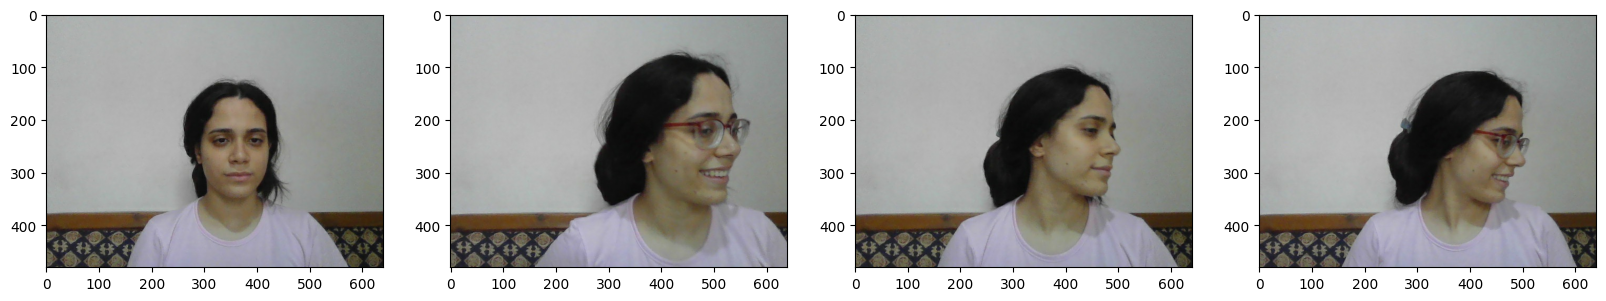

In [25]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data
## 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [26]:
90*.7 # 63 to train


62.99999999999999

In [27]:
90*.15 # 14 and 13 to test and val


13.5

## 3.2 Move the Matching Labels

In [29]:
import os 
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)  

# 4. Apply Image Augmentation on Images and Labels using Albumentations
## 4.1 Setup Albumentations Transform Pipeline

In [7]:
import albumentations as alb

In [8]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

## 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [9]:
img = cv2.imread(os.path.join('data','train', 'images','b97aa6b4-3c3c-11ef-8216-f2a6548e6983.jpg'))

In [10]:
with open(os.path.join('data', 'train', 'labels', 'b97aa6b4-3c3c-11ef-8216-f2a6548e6983.json'), 'r') as f:
    label = json.load(f)

In [11]:
label['shapes'][0]['points']

[[201.1111111111111, 98.88888888888889],
 [497.22222222222223, 383.8888888888889]]

## 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [12]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [13]:
coords

[201.1111111111111, 98.88888888888889, 497.22222222222223, 383.8888888888889]

In [14]:
coords = list(np.divide(coords, [640,480,640,480]))

In [15]:
coords

[0.31423611111111105,
 0.20601851851851852,
 0.7769097222222222,
 0.7997685185185186]

## 4.4 Apply Augmentations and View Results

In [16]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [17]:
augmented['bboxes'][0][2:]

(0.722716049382716, 0.8419753086419753)

In [18]:
augmented['bboxes']


[(0.0646913580246913,
  0.20864197530864198,
  0.722716049382716,
  0.8419753086419753)]

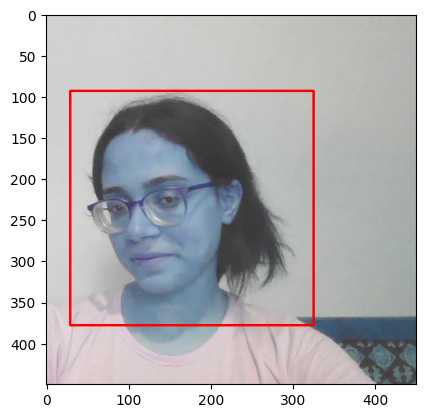

In [19]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline
## 5.1 Run Augmentation Pipeline

In [47]:
import os
import cv2
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))
        img.flags.writeable = True
        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)
   



## 5.2 Load Augmented Images to Tensorflow Dataset

In [48]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [49]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [50]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [84]:
train_images.as_numpy_iterator().next()

array([[[0.6720588 , 0.67990196, 0.6759804 ],
        [0.6738971 , 0.68235296, 0.6784314 ],
        [0.6653799 , 0.68106616, 0.6771446 ],
        ...,
        [0.7642157 , 0.7642157 , 0.7642157 ],
        [0.7607843 , 0.7607843 , 0.7607843 ],
        [0.7598652 , 0.7598652 , 0.7598652 ]],

       [[0.67873776, 0.6865809 , 0.6826593 ],
        [0.6745098 , 0.68235296, 0.6784314 ],
        [0.67058825, 0.6784314 , 0.6745098 ],
        ...,
        [0.7647059 , 0.7647059 , 0.7647059 ],
        [0.7607843 , 0.7607843 , 0.7607843 ],
        [0.75900733, 0.75900733, 0.75900733]],

       [[0.675     , 0.68284315, 0.6789216 ],
        [0.67401963, 0.6818628 , 0.6779412 ],
        [0.6706495 , 0.67849267, 0.6745711 ],
        ...,
        [0.7637868 , 0.7637868 , 0.7637868 ],
        [0.7607843 , 0.7607843 , 0.7607843 ],
        [0.7629289 , 0.7629289 , 0.7629289 ]],

       ...,

       [[0.678125  , 0.6663603 , 0.74871325],
        [0.67107844, 0.65931374, 0.7406863 ],
        [0.6460784 , 0

# 6. Prepare Labels
## 6.1 Build Label Loading Function

In [52]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

## 6.2 Load Labels to Tensorflow Dataset

In [53]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [54]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [55]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [56]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.058 , 0.181 , 0.6357, 0.7935], dtype=float16))

# 7. Combine Label and Image Samples
## 7.1 Check Partition Lengths

In [37]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 840, 840, 840, 840)

## 7.2 Create Final Datasets (Images/Labels)

In [57]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [58]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [59]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [60]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.3108 , 0.05777, 1.     , 0.9946 ],
        [0.5815 , 0.0442 , 0.954  , 0.4727 ],
        [0.271  , 0.1637 , 0.7563 , 0.7314 ],
        [0.4517 , 0.1888 , 1.     , 0.8394 ],
        [0.     , 0.1849 , 0.494  , 0.8296 ],
        [0.1827 , 0.1901 , 0.8433 , 0.863  ],
        [0.293  , 0.03802, 0.6943 , 0.4404 ],
        [0.     , 0.1501 , 0.52   , 0.834  ]], dtype=float16))

## 7.3 View Images and Annotations

In [61]:
data_samples = train.as_numpy_iterator()

In [62]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


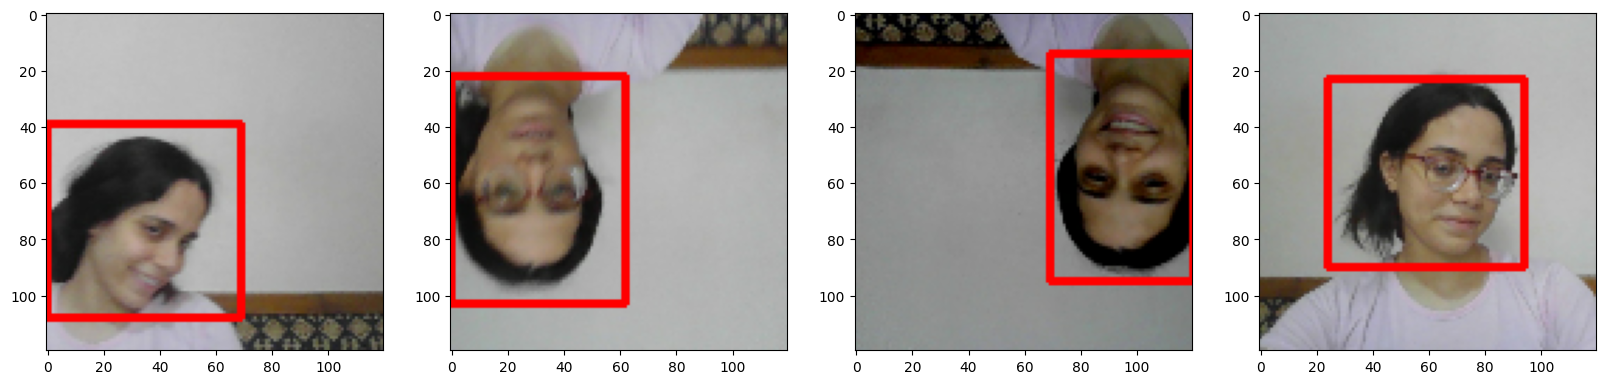

In [66]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx].copy()
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API
## 8.1 Import Layers and Base Network

In [67]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

## 8.2 Download VGG16

In [68]:
vgg = VGG16(include_top=False)

58892288/58889256 [==============================] - 74s 1us/step


In [69]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

## 8.3 Build instance of Network

In [70]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

## 8.4 Test out Neural Network

In [71]:
facetracker = build_model()

In [72]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 120, 120, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, None, None, 5 14714688    input_2[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d (GlobalMax (None, 512)          0           vgg16[0][0]                      
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 512)          0           vgg16[0][0]                      
______________________________________________________________________________________________

In [73]:
X, y = train.as_numpy_iterator().next()

In [74]:
X.shape

(8, 120, 120, 3)

In [75]:
classes, coords = facetracker.predict(X)

In [76]:
classes, coords

(array([[0.48989853],
        [0.43320563],
        [0.39556813],
        [0.36583602],
        [0.4109859 ],
        [0.46371382],
        [0.42655653],
        [0.4437974 ]], dtype=float32),
 array([[0.39771652, 0.53119165, 0.4843813 , 0.6149665 ],
        [0.39447173, 0.4363949 , 0.59249073, 0.6842991 ],
        [0.3745414 , 0.50867116, 0.59073573, 0.67861944],
        [0.4212569 , 0.49682802, 0.57749707, 0.6380825 ],
        [0.43835387, 0.47317153, 0.55424166, 0.65532327],
        [0.42615414, 0.47960544, 0.5757473 , 0.6268986 ],
        [0.38503394, 0.48117745, 0.56350267, 0.63057685],
        [0.37497208, 0.52144176, 0.50037414, 0.5647456 ]], dtype=float32))

# 9. Define Losses and Optimizers
## 9.1 Define Optimizer and LR

In [77]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [78]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)


## 9.2 Create Localization Loss and Classification Loss

In [79]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [80]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

## 9.3 Test out Loss Metrics

In [81]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.2423267>

In [82]:
classloss(y[0], classes)


<tf.Tensor: shape=(), dtype=float32, numpy=0.8506477>

In [83]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.2423267>

# 10. Train Neural Network
## 10.1 Create Custom Model Class

In [85]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [86]:
model = FaceTracker(facetracker)

In [87]:
model.compile(opt, classloss, regressloss)

## 10.2 Train

In [88]:
logdir='logs'


In [89]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [90]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/10
473/473 [==============================] - 179s 331ms/step - total_loss: 0.0983 - class_loss: 0.0054 - regress_loss: 0.0956 - val_total_loss: 0.0233 - val_class_loss: 3.1144e-06 - val_regress_loss: 0.0233
Epoch 2/10
473/473 [==============================] - 151s 299ms/step - total_loss: 0.0255 - class_loss: 6.7779e-06 - regress_loss: 0.0255 - val_total_loss: 2.2246 - val_class_loss: 1.9062 - val_regress_loss: 1.2715
Epoch 3/10
473/473 [==============================] - 152s 298ms/step - total_loss: 0.0165 - class_loss: 2.6738e-06 - regress_loss: 0.0165 - val_total_loss: 0.0441 - val_class_loss: 7.1526e-07 - val_regress_loss: 0.0441
Epoch 4/10
473/473 [==============================] - 151s 298ms/step - total_loss: 0.0108 - class_loss: 1.0990e-06 - regress_loss: 0.0108 - val_total_loss: 0.0475 - val_class_loss: 5.2154e-07 - val_regress_loss: 0.0475
Epoch 5/10
473/473 [==============================] - 152s 299ms/step - total_loss: 0.0099 - class_loss: 8.4692e-07 - regress_lo

## 10.3 Plot Performance

In [92]:
hist.history

{'total_loss': [0.014447123743593693,
  0.005675927270203829,
  0.0032912343740463257,
  0.001541564124636352,
  0.003674932522699237,
  0.00844159722328186,
  0.0015117836883291602,
  0.0016532434383407235,
  0.004298035055398941,
  0.0009491823147982359],
 'class_loss': [2.1577183360932395e-05,
  3.7551060358964605e-06,
  2.4437970296276035e-06,
  5.364422008824477e-07,
  2.384186643666908e-07,
  4.470351484542334e-07,
  1.490116545710407e-07,
  3.546496827766532e-06,
  2.980232594040899e-08,
  -0.0],
 'regress_loss': [0.014436335302889347,
  0.005674049723893404,
  0.00329001247882843,
  0.0015412959037348628,
  0.003674813313409686,
  0.008441373705863953,
  0.001511709182523191,
  0.0016514702001586556,
  0.004298020154237747,
  0.0009491823147982359],
 'val_total_loss': [0.023264307528734207,
  2.224616527557373,
  0.04409787431359291,
  0.047477979212999344,
  0.04623698443174362,
  2.3394925594329834,
  6.800552845001221,
  2.2109687328338623,
  0.054214492440223694,
  2.240781

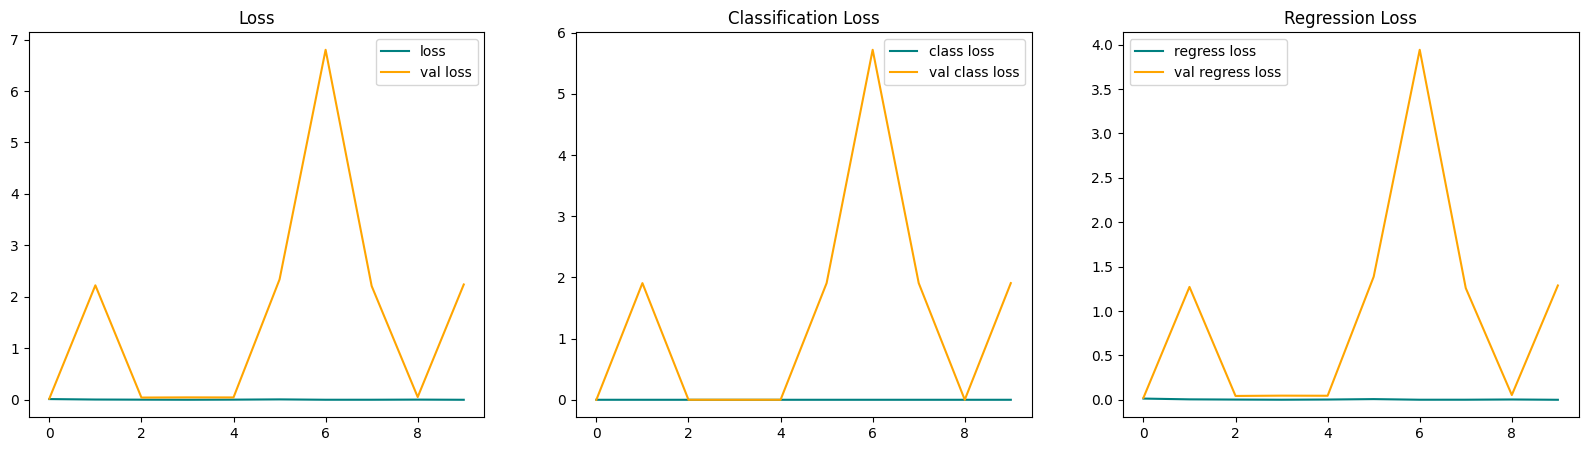

In [93]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions
## 11.1 Make Predictions on Test Set


In [94]:
test_data = test.as_numpy_iterator()


In [95]:
test_sample = test_data.next()


In [96]:
yhat = facetracker.predict(test_sample[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


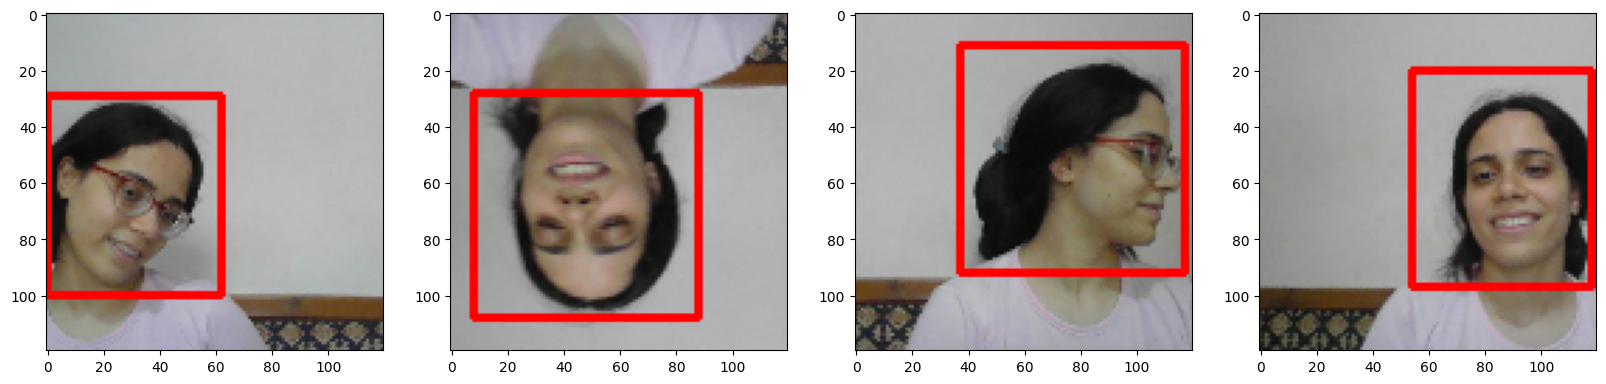

In [98]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx].copy()
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

## 11.2 Save the Model

In [115]:
from tensorflow.keras.models import load_model

In [116]:
facetracker.save('facetracker.h5')

In [117]:
facetracker = load_model('facetracker.h5')

## 11.3 Real Time Detection

In [120]:
import cv2
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()